In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import obspy
from datetime import datetime
from hydrophone_data_processing import load, useful_variables, plotting, signal_processing

# def import_data(day, starttime, endtime):
# def import_data(day):
#     daypaths = useful_variables.make_hydrophone_data_paths(borehole='a', year=2019, julian_day=day)
#     data = load.import_corrected_data_for_single_day(daypaths)
#     # data.trim(starttime=starttime, endtime=endtime)
#     return data

plt.rcParams.update({'font.size': 15})


In [2]:
# import p[ressure data
ba1d_otherpt = pd.read_excel('~/data/timeseries/BA1D_p_T_2019_2020_1.xlsx')
ba1d_otherpt.columns = [c.strip() for c in ba1d_otherpt.columns]
ba1d_otherpt['Date and Time'] = pd.to_datetime(ba1d_otherpt['Date and Time'])

# import breakouts data
df141 = pd.read_csv('/home/mnky9800n/data/timeseries/141precision.csv')
df188 = pd.read_csv('/home/mnky9800n/data/timeseries/188precision.csv')
df197 = pd.read_csv('/home/mnky9800n/data/timeseries/197precision.csv')
df211 = pd.read_csv('/home/mnky9800n/data/timeseries/211precision.csv')

ba1a_breakouts = pd.concat([df141, df188, df197, df211])
ba1a_breakouts['ot_dt'] = ba1a_breakouts.origin_time.apply(lambda t: pd.to_datetime(obspy.UTCDateTime(t).datetime))
ba1a_breakouts = ba1a_breakouts.groupby(['depth', pd.Grouper(key='ot_dt', freq='1min')]).count().reset_index()[['ot_dt', 'id']]
ba1a_breakouts.sort_values(by='ot_dt', inplace=True)
ba1a_breakouts['cumulative_events'] = ba1a_breakouts['id'].cumsum()
ba1a_breakouts.reset_index(inplace=True)

ba1a_breakouts_start = ba1d_otherpt.iloc[0]['Date and Time']
ba1a_breakouts_end = ba1d_otherpt.iloc[-1]['Date and Time']

ba1a_t = [np.datetime64(ba1a_breakouts_start),] +  list(ba1a_breakouts['ot_dt'].values) + [np.datetime64(ba1a_breakouts_end),]
ba1a_y = [0,] + list(ba1a_breakouts['cumulative_events'].values) + [ba1a_breakouts.cumulative_events.max(),]

# import precip data
precipitation = pd.read_csv('/home/mnky9800n/data/timeseries/daily_precipitation.csv')
precipitation.columns = ['datetime', 'total_precip']
precipitation['datetime'] = pd.to_datetime(precipitation['datetime'])
precipitation

# # import surface pressure data
# pressure = pd.read_csv('/home/mnky9800n/data/timeseries/daily_surfacepressure.csv')
# pressure.columns = ['datetime', 'total_pressure']
# pressure['datetime'] = pd.to_datetime(pressure['datetime'])
# pressure['total_pressure'] = pressure['total_pressure'].apply(lambda p: float(p.replace(',', '')))

# # import bubbles data
# bubbles = load.import_bubble_detections('/home/mnky9800n/data/detections/detections/B*.csv')
# bubbles.reset_index(inplace=True)
# bubbles_t = [np.datetime64(ba1a_breakouts_start),] + list(bubbles['time'].values) + [np.datetime64(ba1a_breakouts_end),]
# bubbles_y = [0,] + list(bubbles['ones'].cumsum()) + [bubbles['ones'].sum(),]

,datetime,total_precip
0,2019-01-01,0.0
1,2019-01-02,0.0
2,2019-01-03,0.0
3,2019-01-04,0.0
4,2019-01-05,0.0
...,...,...
420,2020-02-25,0.0
421,2020-02-26,0.0
422,2020-02-27,0.0
423,2020-02-28,0.0


In [3]:
# bubbles.dtypes

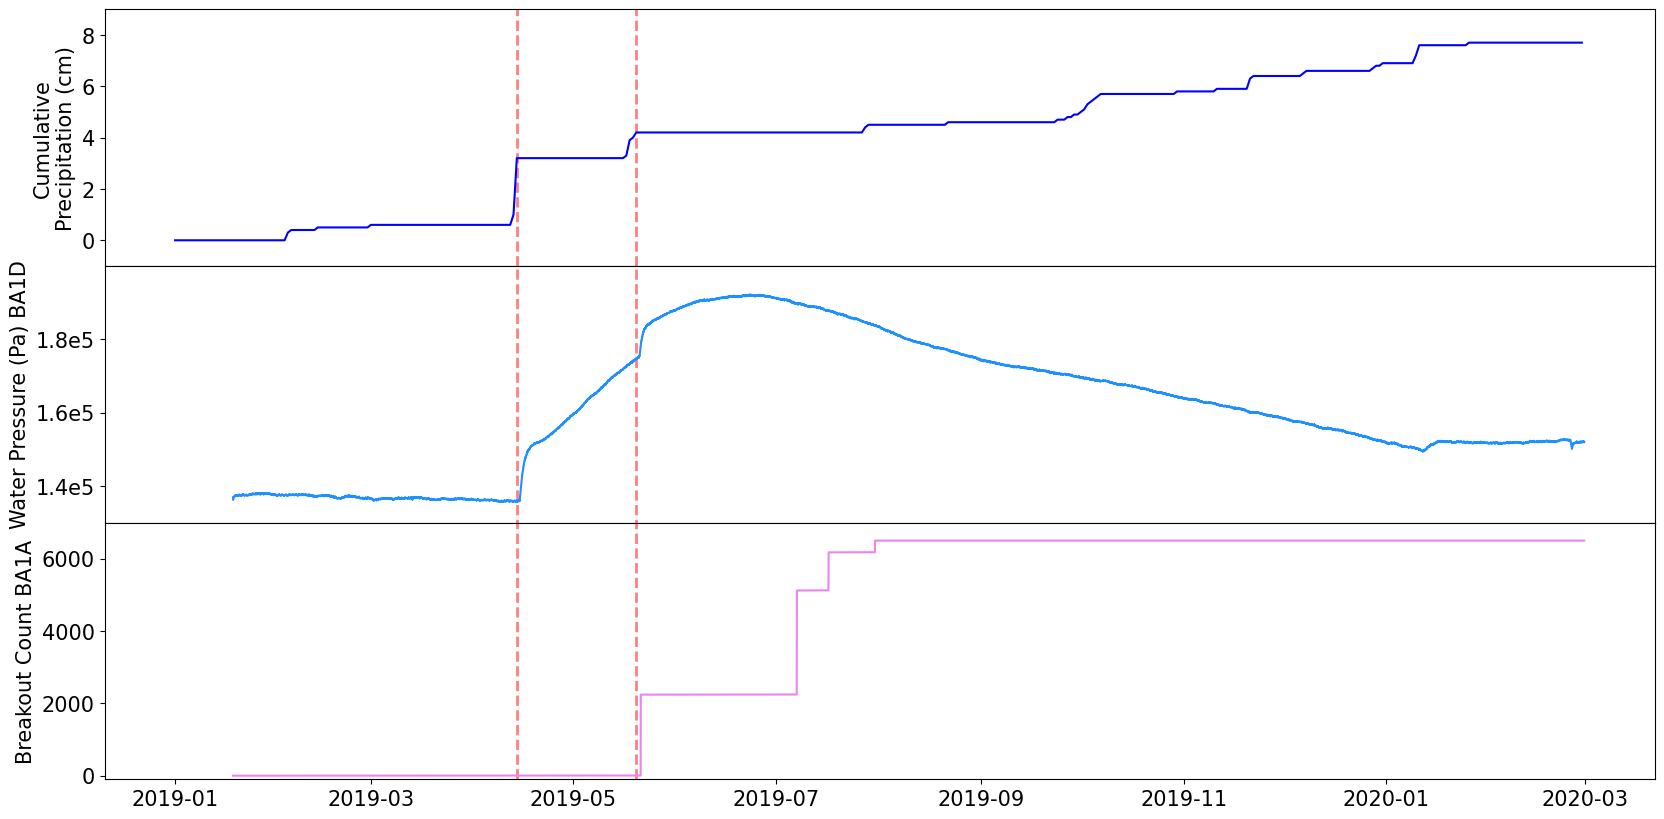

In [13]:
# %matplotlib widget
fig, ax = plt.subplots(3, 1, figsize=(20, 10), sharex=True)

ax[0].set_ylabel('Cumulative\nPrecipitation (cm)')
ax[1].set_ylabel('Water Pressure (Pa) BA1D')
ax[2].set_ylabel('Breakout Count BA1A')

ax[0].set_ylim(-1, 9)
ax[1].set_ylim(1.3e5, 2.0e5)
ax[2].set_ylim(-100, 7000)

ax[0].plot(precipitation['datetime'], precipitation['total_precip'].cumsum()*100, color='blue')

ax[1].plot(ba1d_otherpt['Date and Time'], ba1d_otherpt['Pressure (Bar)']*100000, color='dodgerblue')

ax[2].plot(ba1a_t, ba1a_y, color='violet')

ax[1].set_yticks([140000, 160000, 180000])
ax[1].set_yticklabels(['1.4e5', '1.6e5', '1.8e5'])


ax[0].vlines(x=pd.to_datetime('2019-04-14'), linestyle='--', ymin=-5, ymax=10, color='red', zorder=0, alpha=0.5,linewidth=2)
ax[1].vlines(x=pd.to_datetime('2019-04-14'), linestyle='--', ymin=1.2e5, ymax=2.0e5, color='red', zorder=0, alpha=0.5,linewidth=2)
ax[2].vlines(x=pd.to_datetime('2019-04-14'), linestyle='--', ymin=-100, ymax=7000, color='red', zorder=0, alpha=0.5,linewidth=2)

ax[0].vlines(x=pd.to_datetime('2019-05-20'), linestyle='--', ymin=-5, ymax=10, color='red', zorder=0, alpha=0.5,linewidth=2)
ax[1].vlines(x=pd.to_datetime('2019-05-20'), linestyle='--', ymin=1.2e5, ymax=2.0e5, color='red', zorder=0, alpha=0.5,linewidth=2)
ax[2].vlines(x=pd.to_datetime('2019-05-20'), linestyle='--', ymin=-100, ymax=7000, color='red', zorder=0, alpha=0.5,linewidth=2)

fig.subplots_adjust(hspace=0)
# fig.tight_layout()
fig.savefig('fig6.pdf', bbox_inches='tight')

In [5]:
# hdata248 = import_data(day=248)

In [6]:
1.4e5

140000.0